Import section

In [139]:
import pandas as pd
import os
import numpy as np

from pandas import DataFrame
from math import sqrt
from numpy import split
from numpy import array
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Activation

Constants

In [140]:
FILES_FOLDER_PATH = 'files_cambridgeshire_bedfordshire'
FILE_NAME = 'cambridgeshire_bedfordshire.csv'

Loading dataset

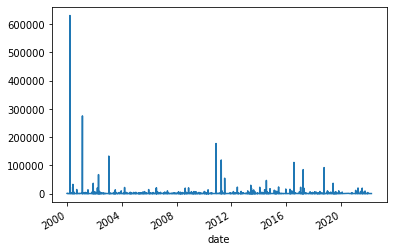

5191  entries


In [141]:
df = pd.read_csv(os.path.join(FILES_FOLDER_PATH, FILE_NAME), header=0, index_col=0)
df.index = pd.to_datetime(df.index)
df = df.sort_values('date', ascending=True)
df['wqi'].plot()
pyplot.show()
total = len(df)
print(total, " entries")

Removing outliers

In [142]:
def remove_outliers(df: DataFrame):
    Q1 = np.percentile(df['wqi'], 25,
                   interpolation = 'midpoint')
 
    Q3 = np.percentile(df['wqi'], 75,
                    interpolation = 'midpoint')
    IQR = Q3 - Q1
    ''' Removing the Outliers '''
    df = df[(df['wqi'] > (Q1 - 1.5 * IQR)) & (df['wqi'] < (Q3 + 1.5 * IQR))]
    return df

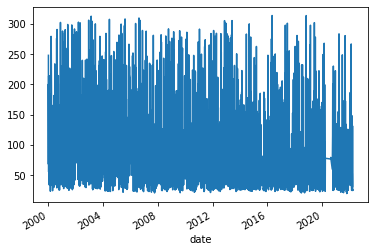

739  out of  5191  entries removed.


In [143]:
df = remove_outliers(df)
df['wqi'].plot()
pyplot.show()
print(total - len(df), " out of ", total, " entries removed.")

Conversion to supervised learning

In [144]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	print(names)
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [145]:
FORECAST_STEP = 1
PREVIOUS_STEP = 7
values = df.values
# number of features equels to number of columns - independent feature
n_features = len(df.columns)
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, PREVIOUS_STEP, FORECAST_STEP)
print(reframed.head())

['var1(t-7)', 'var2(t-7)', 'var3(t-7)', 'var4(t-7)', 'var5(t-7)', 'var6(t-7)', 'var7(t-7)', 'var8(t-7)', 'var9(t-7)', 'var10(t-7)', 'var11(t-7)', 'var1(t-6)', 'var2(t-6)', 'var3(t-6)', 'var4(t-6)', 'var5(t-6)', 'var6(t-6)', 'var7(t-6)', 'var8(t-6)', 'var9(t-6)', 'var10(t-6)', 'var11(t-6)', 'var1(t-5)', 'var2(t-5)', 'var3(t-5)', 'var4(t-5)', 'var5(t-5)', 'var6(t-5)', 'var7(t-5)', 'var8(t-5)', 'var9(t-5)', 'var10(t-5)', 'var11(t-5)', 'var1(t-4)', 'var2(t-4)', 'var3(t-4)', 'var4(t-4)', 'var5(t-4)', 'var6(t-4)', 'var7(t-4)', 'var8(t-4)', 'var9(t-4)', 'var10(t-4)', 'var11(t-4)', 'var1(t-3)', 'var2(t-3)', 'var3(t-3)', 'var4(t-3)', 'var5(t-3)', 'var6(t-3)', 'var7(t-3)', 'var8(t-3)', 'var9(t-3)', 'var10(t-3)', 'var11(t-3)', 'var1(t-2)', 'var2(t-2)', 'var3(t-2)', 'var4(t-2)', 'var5(t-2)', 'var6(t-2)', 'var7(t-2)', 'var8(t-2)', 'var9(t-2)', 'var10(t-2)', 'var11(t-2)', 'var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)', 'var7(t-1)', 'var8(t-1)', 'var9(t-1)', 'var10(t-1)'

In [146]:
# split into train and test sets
values = reframed.values
n_train = int(len(values) * 0.8)
train = values[:n_train, :]
test = values[n_train:, :]
# split train into train and val sets
n_val_train = int(len(train) * 0.7)
val = train[n_val_train:, :]
train = train[:n_val_train, :]
# split into input and outputs
n_inputs = n_features * PREVIOUS_STEP
train_X, train_y = train[:, :n_inputs], train[:, -1]
val_X, val_y = val[:, :n_inputs], val[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], PREVIOUS_STEP, n_features))
val_X = val_X.reshape((val_X.shape[0], PREVIOUS_STEP, n_features))

test_X, test_y = test[:, :n_inputs], test[:, -1]
test_X = test_X.reshape((test_X.shape[0], PREVIOUS_STEP, n_features))
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)

(2489, 7, 11) (2489,) (1067, 7, 11) (1067,) (889, 7, 11) (889,)


Epoch 1/50
39/39 - 3s - loss: 0.0502 - val_loss: 0.0360 - 3s/epoch - 75ms/step
Epoch 2/50
39/39 - 1s - loss: 0.0417 - val_loss: 0.0356 - 1s/epoch - 32ms/step
Epoch 3/50
39/39 - 1s - loss: 0.0416 - val_loss: 0.0356 - 1s/epoch - 30ms/step
Epoch 4/50
39/39 - 1s - loss: 0.0416 - val_loss: 0.0356 - 1s/epoch - 29ms/step
Epoch 5/50
39/39 - 1s - loss: 0.0415 - val_loss: 0.0355 - 1s/epoch - 29ms/step
Epoch 6/50
39/39 - 1s - loss: 0.0414 - val_loss: 0.0355 - 1s/epoch - 29ms/step
Epoch 7/50
39/39 - 1s - loss: 0.0413 - val_loss: 0.0355 - 1s/epoch - 29ms/step
Epoch 8/50
39/39 - 1s - loss: 0.0413 - val_loss: 0.0356 - 1s/epoch - 29ms/step
Epoch 9/50
39/39 - 1s - loss: 0.0411 - val_loss: 0.0356 - 1s/epoch - 29ms/step
Epoch 10/50
39/39 - 1s - loss: 0.0411 - val_loss: 0.0356 - 1s/epoch - 29ms/step
Epoch 11/50
39/39 - 1s - loss: 0.0410 - val_loss: 0.0356 - 1s/epoch - 29ms/step
Epoch 12/50
39/39 - 1s - loss: 0.0410 - val_loss: 0.0356 - 1s/epoch - 31ms/step
Epoch 13/50
39/39 - 1s - loss: 0.0409 - val_loss:

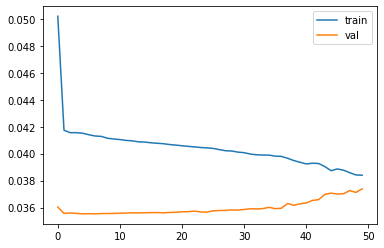

In [147]:
# design network
model = Sequential()

model.add(LSTM(200, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(200, activation='relu'))
model.add(Dense(FORECAST_STEP))
model.add(Activation('linear'))
model.compile(loss='mse', optimizer='adam')

# model.add(LSTM(200, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(Dense(100, activation='relu'))
# model.add(Dense(1))
# model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=64, validation_data=(val_X, val_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

In [148]:
# make a prediction
yhat = model.predict(test_X, verbose=2)
test_X = test_X.reshape((test_X.shape[0], n_inputs))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -(n_features - 1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -(n_features - 1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

28/28 - 0s - 331ms/epoch - 12ms/step
Test RMSE: 4.571
